In [24]:
%%capture 
pip install torch pytorch-lightning pytorch_forecasting

In [25]:
import warnings
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

# Extented Time-Series Format

In [26]:
sample_data = pd.DataFrame(
    dict(
        time_idx=np.tile(np.arange(6), 3),
        target=np.array([0,1,2,3,4,5,20,21,22,23,24,25,40,41,42,43,44,45]),
        group=np.repeat(np.arange(3), 6),
        holidays = np.tile(['X','Black Friday', 'X','Christmas','X', 'X'],3),
    )
)
sample_data

,time_idx,target,group,holidays
0,0,0,0,X
1,1,1,0,Black Friday
2,2,2,0,X
3,3,3,0,Christmas
4,4,4,0,X
5,5,5,0,X
6,0,20,1,X
7,1,21,1,Black Friday
8,2,22,1,X
9,3,23,1,Christmas


In [27]:
# create the time-series dataset from the pandas df
dataset = TimeSeriesDataSet(
    sample_data,
    group_ids=["group"],
    target="target",
    time_idx="time_idx",
    max_encoder_length=2,
    max_prediction_length=3,
    time_varying_unknown_reals=["target"],
    static_categoricals=["holidays"],
    target_normalizer=None
)

# pass the dataset to a dataloader
dataloader = dataset.to_dataloader(batch_size=1)

#load the first batch
x, y = next(iter(dataloader))
print(x['encoder_target'])
print(x['groups'])
print('\n')
print(x['decoder_target'])

tensor([[0., 1.]])
tensor([[0]])


tensor([[2., 3., 4.]])


# Energy Demand Forecasting with Temporal Fusion Transformer

### Download the dataset

In [28]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip
!unzip LD2011_2014.txt.zip

--2023-03-30 04:48:13--  https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261335609 (249M) [application/x-httpd-php]
Saving to: ‘LD2011_2014.txt.zip.1’

LD2011_2014.txt.zip 100%[===================>] 249.23M  16.9MB/s    in 16s     

2023-03-30 04:48:30 (15.9 MB/s) - ‘LD2011_2014.txt.zip.1’ saved [261335609/261335609]

Archive:  LD2011_2014.txt.zip
replace LD2011_2014.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: LD2011_2014.txt         
replace __MACOSX/._LD2011_2014.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._LD2011_2014.txt  


### Data Preprocessing

In [29]:
data = pd.read_csv('LD2011_2014.txt', index_col=0, sep=';', decimal=',')
data.index = pd.to_datetime(data.index)
data.sort_index(inplace=True)
data.head(5)
# Each column represents a consumer. Most initial power_usage values are 0.
# Next, we aggregate to hourly data. Due to the model’s size and complexity, we train our model on 5 consumers only (for 
# those with non-zero values).

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# Now, we prepare our dataset for the TimeSeriesDataset format. Notice that each column represents a different time-series. 
# Hence, we ‘melt’ our dataframe, so that all time-series are stacked vertically instead of horizontally. In the process, 
# we create our new features.

data = data.resample('1h').mean().replace(0., np.nan)
earliest_time = data.index.min()
df=data[['MT_002',	'MT_004',	'MT_005',	'MT_006',	'MT_008' ]]

In [31]:
df_list = []

for label in df:

    ts = df[label]

    start_date = min(ts.fillna(method='ffill').dropna().index)
    end_date = max(ts.fillna(method='bfill').dropna().index)

    active_range = (ts.index >= start_date) & (ts.index <= end_date)
    ts = ts[active_range].fillna(0.)

    tmp = pd.DataFrame({'power_usage': ts})
    date = tmp.index

    tmp['hours_from_start'] = (date - earliest_time).seconds / 60 / 60 + (date - earliest_time).days * 24
    tmp['hours_from_start'] = tmp['hours_from_start'].astype('int')
  
    tmp['days_from_start'] = (date - earliest_time).days
    tmp['date'] = date
    tmp['consumer_id'] = label
    tmp['hour'] = date.hour
    tmp['day'] = date.day
    tmp['day_of_week'] = date.dayofweek
    tmp['month'] = date.month

    #stack all time series vertically
    df_list.append(tmp)

time_df = pd.concat(df_list).reset_index(drop=True)

# match results in the original paper
time_df = time_df[(time_df['days_from_start'] >= 1096)
                & (time_df['days_from_start'] < 1346)].copy()


In [32]:
time_df

,power_usage,hours_from_start,days_from_start,date,consumer_id,hour,day,day_of_week,month
17544,24.004267,26304,1096,2014-01-01 00:00:00,MT_002,0,1,2,1
17545,23.293030,26305,1096,2014-01-01 01:00:00,MT_002,1,1,2,1
17546,24.537696,26306,1096,2014-01-01 02:00:00,MT_002,2,1,2,1
17547,21.870555,26307,1096,2014-01-01 03:00:00,MT_002,3,1,2,1
17548,22.226174,26308,1096,2014-01-01 04:00:00,MT_002,4,1,2,1
...,...,...,...,...,...,...,...,...,...
128759,249.158249,32299,1345,2014-09-07 19:00:00,MT_008,19,7,6,9
128760,303.030303,32300,1345,2014-09-07 20:00:00,MT_008,20,7,6,9
128761,306.397306,32301,1345,2014-09-07 21:00:00,MT_008,21,7,6,9
128762,279.461279,32302,1345,2014-09-07 22:00:00,MT_008,22,7,6,9


In [33]:
# The time_df is now in the proper format for the TimeSeriesDataset. As you have guessed by now, since the granularity is 
# hourly, the hours_from_start variable will be the time index.

### Exploratory Data Aanalysis

In [34]:
# The choice of 5 consumers/time-series is not random. The power usage of each time-series has different properties, such as
# the mean value:
time_df.query(" hours_from_start==26304")

,power_usage,hours_from_start,days_from_start,date,consumer_id,hour,day,day_of_week,month
17544,24.004267,26304,1096,2014-01-01,MT_002,0,1,2,1
43849,148.882114,26304,1096,2014-01-01,MT_004,0,1,2,1
70154,75.609756,26304,1096,2014-01-01,MT_005,0,1,2,1
96459,276.041667,26304,1096,2014-01-01,MT_006,0,1,2,1
122764,247.474747,26304,1096,2014-01-01,MT_008,0,1,2,1


In [35]:
time_df[['consumer_id','power_usage']].groupby('consumer_id').mean()

,power_usage
consumer_id,
MT_002,27.472588
MT_004,120.573001
MT_005,50.958384
MT_006,183.387773
MT_008,248.884259


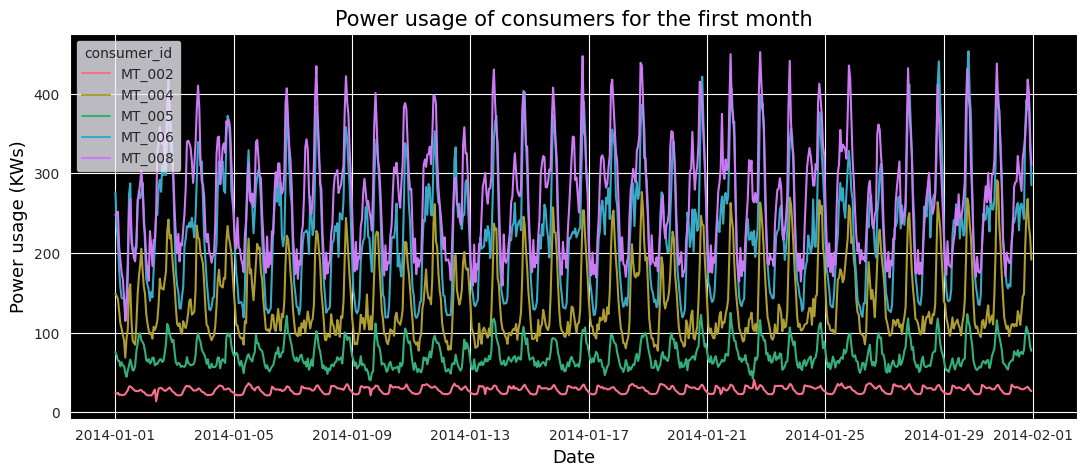

In [36]:
# Let’s plot the first month of every time-series:

import seaborn as sns
import matplotlib.pyplot as plt

#plt.rcParams.update(plt.rcParamsDefault)
sns.set_style('darkgrid')
sns.color_palette("tab10")

fig, ax = plt.subplots(figsize=(13, 5))

sns.lineplot(data=time_df[time_df['month'] == 1], 
             x='date', 
             y='power_usage', 
             hue='consumer_id', 
             legend='full',
             palette='husl').set_title('Power usage per consumers')

ax.set_xlabel("Date", fontdict={"color":  "black", "size": 13} )
ax.set_ylabel("Power usage (KWs)", fontdict={"color":  "black", "size": 13})
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax.set_title(label = "Power usage of consumers for the first month", fontdict={"color":  "black", "size": 15})
ax.set_facecolor("black")

# each time-series has slightly different seasonality and amplitude

# notice that other time-series forecasting methods like ARIMA must satisfy a few requirements (for instance, the 
# time-series must first become stationary.) With TFT, we can leave our data as-is

### Data Preparation

In [37]:
# Our model uses a lookback window of one week (7*24) to predict the power usage of the next 24 hours.

# notice that the hours_from_start is both the time index and a time-varying feature. The power_usage is our target variable.
# For the sake of demonstration, our validation set is the last day

#Hyperparameters
#batch size=64
#number heads=4, hidden sizes=160, lr=0.001, gr_clip=0.1

max_prediction_length = 24
max_encoder_length = 7*24
training_cutoff = time_df["hours_from_start"].max() - max_prediction_length

training = TimeSeriesDataSet(
    time_df[lambda x: x.hours_from_start <= training_cutoff],
    time_idx="hours_from_start",
    target="power_usage",
    group_ids=["consumer_id"],
    min_encoder_length=max_encoder_length // 2, 
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["consumer_id"],
    time_varying_known_reals=["hours_from_start","day","day_of_week", "month", 'hour'],
    time_varying_unknown_reals=['power_usage'],
    target_normalizer=GroupNormalizer(
        groups=["consumer_id"], transformation="softplus"
    ),  # we normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)


validation = TimeSeriesDataSet.from_dataset(training, time_df, predict=True, stop_randomization=True)

# create dataloaders for  our model
batch_size = 64 
# if you have a strong GPU, feel free to increase the number of workers  
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [38]:
time_df['consumer_id'].value_counts()

MT_002    6000
MT_004    6000
MT_005    6000
MT_006    6000
MT_008    6000
Name: consumer_id, dtype: int64

The **training.index** and **validation.index** show how our training and validation instances are sliced.   
For example, **sequence_length**= **max_encoder_length** + **max_prediction_length**

In [39]:
training.index

,time_first,time_last,time_diff_to_next,index_start,time,count,sequence_id,index_end,sequence_length
0,26304,32279,1,0,26304,5976,0,191,192
1,26304,32279,1,1,26305,5976,0,192,192
2,26304,32279,1,2,26306,5976,0,193,192
3,26304,32279,1,3,26307,5976,0,194,192
4,26304,32279,1,4,26308,5976,0,195,192
...,...,...,...,...,...,...,...,...,...
30410,26304,32279,1,23904,26304,5976,4,24090,187
30411,26304,32279,1,23904,26304,5976,4,24091,188
30412,26304,32279,1,23904,26304,5976,4,24092,189
30413,26304,32279,1,23904,26304,5976,4,24093,190


In [40]:
validation.index

,time_first,time_last,time_diff_to_next,index_start,time,count,sequence_id,index_end,sequence_length
5808,26304,32303,1,5808,32112,6000,0,5999,192
11808,26304,32303,1,11808,32112,6000,1,11999,192
17808,26304,32303,1,17808,32112,6000,2,17999,192
23808,26304,32303,1,23808,32112,6000,3,23999,192
29808,26304,32303,1,29808,32112,6000,4,29999,192


### Baseline Model

In [41]:
# Next, the step that almost everyone forgets: A baseline model. Especially in time-series forecasting, you will be 
# surprised at how often a naive predictor outperforms even a fancier model! As a naive baseline, we predict the power 
# usage curve of the previous day:

actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


25.139617919921875

### Build TFT model

In [42]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=True, mode="min")
lr_logger = LearningRateMonitor()  
logger = TensorBoardLogger("lightning_logs")  

trainer = pl.Trainer(
    max_epochs=45,
    accelerator='gpu', 
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=160,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=10, 
    reduce_on_plateau_patience=4,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [43]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 20    
3  | prescalers                         | ModuleDict                      | 3.2 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 313 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 734 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 628 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 103 K 
8  | static_context_initial_hidde

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 4.666


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.698 >= min_delta = 0.0001. New best score: 3.968


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.230 >= min_delta = 0.0001. New best score: 3.738


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.027 >= min_delta = 0.0001. New best score: 3.711


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 3.711. Signaling Trainer to stop.


In [44]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

lightning_logs/lightning_logs/version_1/checkpoints/epoch=9-step=4680.ckpt


### Save The Model

In [45]:
#zip and download the model
!zip  -r model.zip lightning_logs/lightning_logs/version_1/*

  adding: lightning_logs/lightning_logs/version_1/04680/ (stored 0%)
  adding: lightning_logs/lightning_logs/version_1/04680/consumer_id/ (stored 0%)
  adding: lightning_logs/lightning_logs/version_1/04680/consumer_id/tensors.tsv (deflated 46%)
  adding: lightning_logs/lightning_logs/version_1/04680/consumer_id/metadata.tsv (deflated 40%)
  adding: lightning_logs/lightning_logs/version_1/checkpoints/ (stored 0%)
  adding: lightning_logs/lightning_logs/version_1/checkpoints/epoch=9-step=4680.ckpt (deflated 8%)
  adding: lightning_logs/lightning_logs/version_1/events.out.tfevents.1680152013.9987dc4b5540.131.1 (deflated 9%)
  adding: lightning_logs/lightning_logs/version_1/hparams.yaml (deflated 89%)
  adding: lightning_logs/lightning_logs/version_1/projector_config.pbtxt (deflated 39%)


In [47]:
#load our saved model again
!unzip model.zip
best_model_path='lightning_logs/lightning_logs/version_1/checkpoints/epoch=9-step=4680.ckpt'
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

Archive:  model.zip
replace lightning_logs/lightning_logs/version_0/03744/consumer_id/tensors.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: lightning_logs/lightning_logs/version_0/03744/consumer_id/tensors.tsv  
replace lightning_logs/lightning_logs/version_0/03744/consumer_id/metadata.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: lightning_logs/lightning_logs/version_0/03744/consumer_id/metadata.tsv  
replace lightning_logs/lightning_logs/version_0/checkpoints/epoch=7-step=3744.ckpt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: lightning_logs/lightning_logs/version_0/checkpoints/epoch=7-step=3744.ckpt  
replace lightning_logs/lightning_logs/version_0/events.out.tfevents.1680150409.9987dc4b5540.131.0? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: lightning_logs/lightning_logs/version_0/events.out.tfevents.1680150409.9987dc4b5540.131.0  
replace lightning_logs/lightning_logs/version_0/hparams.yaml? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflatin

### Training and Validation curves on Tensorboard

In [ ]:
# Start tensorboard
%load_ext tensorboard
%tensorboard --logdir lightning_logs

### Evaluate on validation data and plot results

In [49]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

#average p50 loss overall
print((actuals - predictions).abs().mean().item())
#average p50 loss per time series
print((actuals - predictions).abs().mean(axis=1))

6.625116348266602
tensor([ 1.4056,  6.9853,  2.5984, 11.4739, 10.6623])


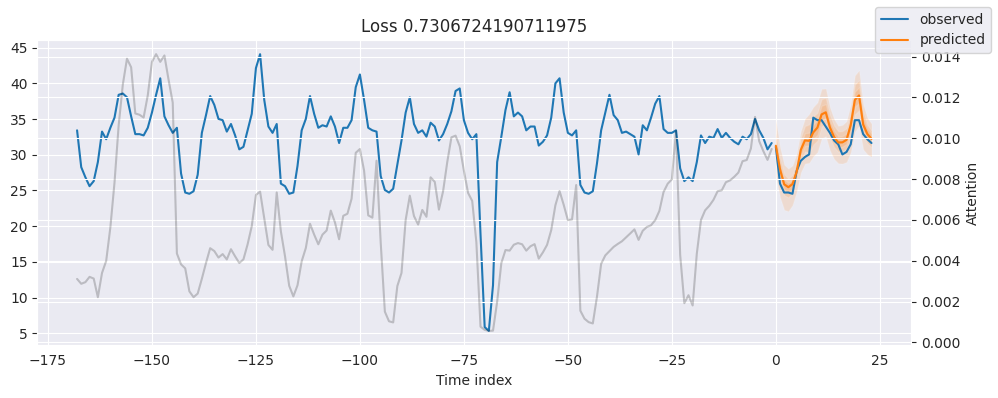

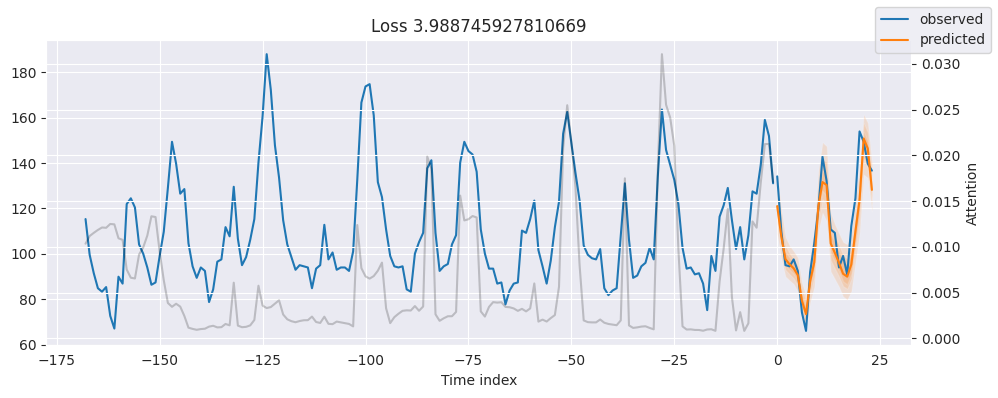

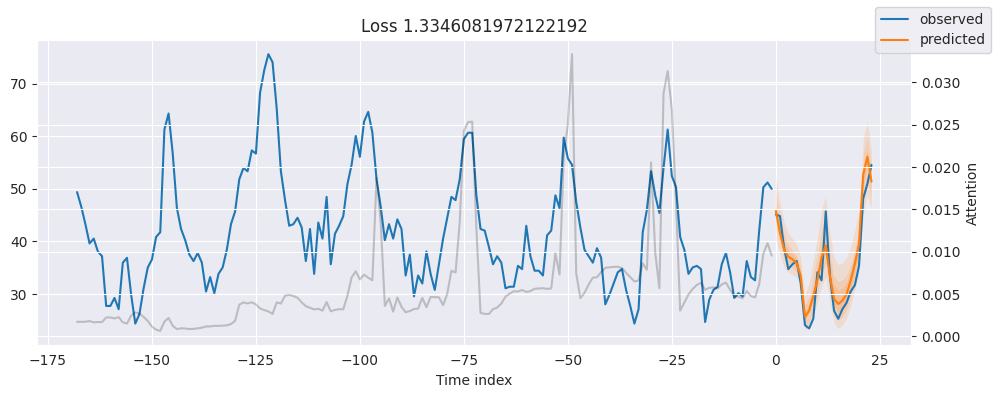

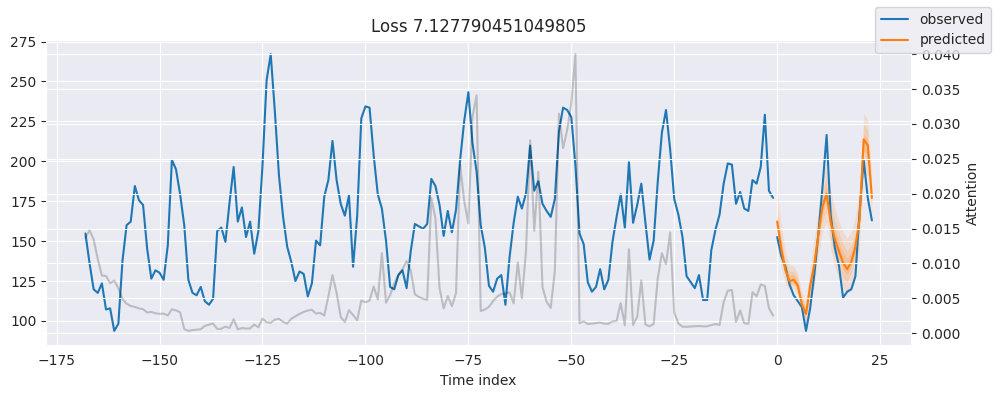

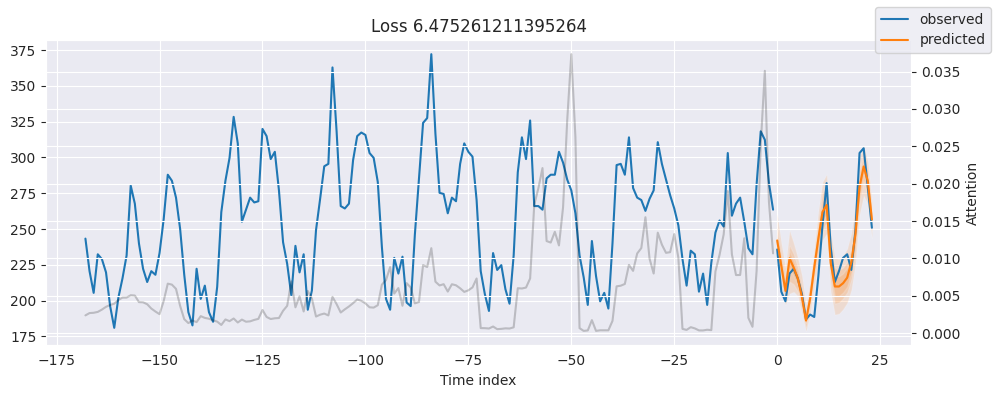

In [50]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

for idx in range(5):  # plot all 5 consumers
    fig, ax = plt.subplots(figsize=(10, 4))
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True,ax=ax)

In [51]:
#Take a look at what the raw_predictions variable contains

raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
print(raw_predictions._fields)
# ('prediction', 
# 'encoder_attention', 
# 'decoder_attention', 
# 'static_variables', 
# 'encoder_variables', 
# 'decoder_variables', 
# 'decoder_lengths', 
# 'encoder_lengths')

print('\n')
print(raw_predictions['prediction'].shape)
#torch.Size([5, 24, 7])

# We get predictions of 5 time-series for 24 days.
# For each day we get 7 predictions - these are the 7 quantiles:
#[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
# We are mostly interested in the 4th quantile which represents, let's say, the 'median loss'
# fyi, although docs use the term quantiles, the most accurate term are percentiles

('prediction', 'encoder_attention', 'decoder_attention', 'static_variables', 'encoder_variables', 'decoder_variables', 'decoder_lengths', 'encoder_lengths')


torch.Size([5, 24, 7])


### Evaluate on a specific Time-Series

We can also evaluate for a specific time series explicitly. Since we already tried on the validation set, we can try on the training set 

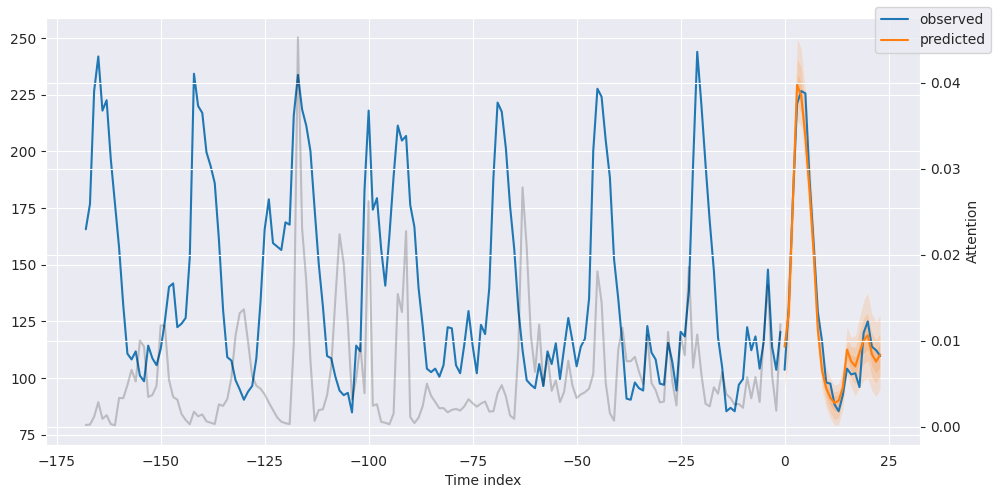

In [52]:
fig, ax = plt.subplots(figsize=(10, 5))

raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.consumer_id == "MT_004") & (x.time_idx_first_prediction == 26512)),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_prediction, idx=0, ax=ax);

In [53]:
26304 + 168//2

26388

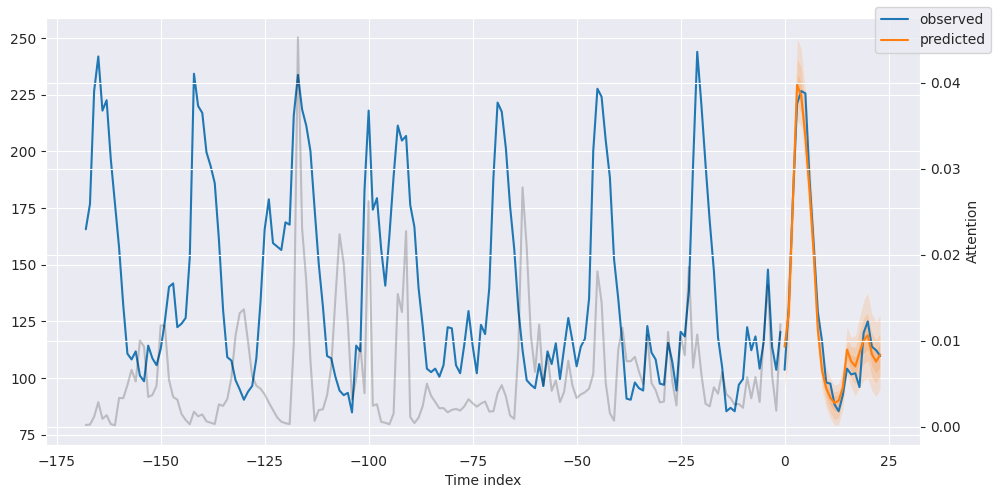

In [55]:
#the minimum time index that we can use is 26388
fig, ax = plt.subplots(figsize=(10, 5))

raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.consumer_id == "MT_004") & (x.time_idx_first_prediction == 26512)),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_prediction, idx=0, ax=ax);

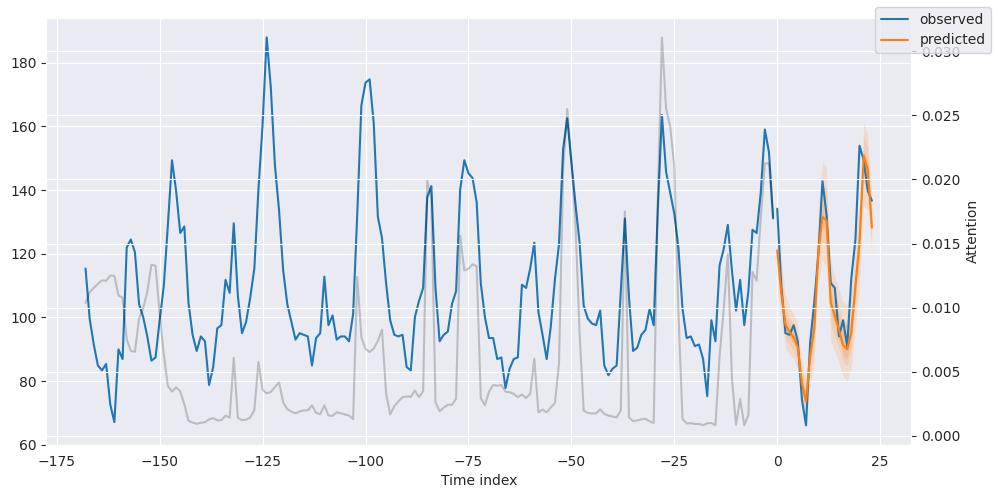

In [56]:
#this is equal to our previous Figure for idx=1
fig, ax = plt.subplots(figsize=(10, 5))

raw_prediction, x = best_tft.predict(
    validation.filter(lambda x: (x.consumer_id == "MT_004")),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_prediction, idx=0, ax=ax);

## Test on new Data

In [57]:
#encoder data is the last lookback window: we get the last 1 week (168 datapoints) for all 5 consumers = 840 total datapoints
encoder_data = time_df[lambda x: x.hours_from_start > x.hours_from_start.max() - max_encoder_length]
last_data = time_df[lambda x: x.hours_from_start == x.hours_from_start.max()]

#decoder_data is the new dataframe for which we will create predictions. 
#decoder_data df should be max_prediction_length* consumers = 24*5=120 datapoints long : 24 datapoints for each cosnumer
#we create it by repeating the last hourly observation of every consumer 24 times since we do not really have new test data
#and later we fix the columns
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.Hour(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

#fix the new columns
decoder_data["hours_from_start"] = (decoder_data["date"] - earliest_time).dt.seconds / 60 / 60 + (decoder_data["date"] - earliest_time).dt.days * 24
decoder_data['hours_from_start'] = decoder_data['hours_from_start'].astype('int')
decoder_data["hours_from_start"] += encoder_data["hours_from_start"].max() + 1 - decoder_data["hours_from_start"].min()

decoder_data["month"] = decoder_data["date"].dt.month.astype(np.int64)
decoder_data["hour"] = decoder_data["date"].dt.hour.astype(np.int64)
decoder_data["day"] = decoder_data["date"].dt.day.astype(np.int64)
decoder_data["day_of_week"] = decoder_data["date"].dt.dayofweek.astype(np.int64)

new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

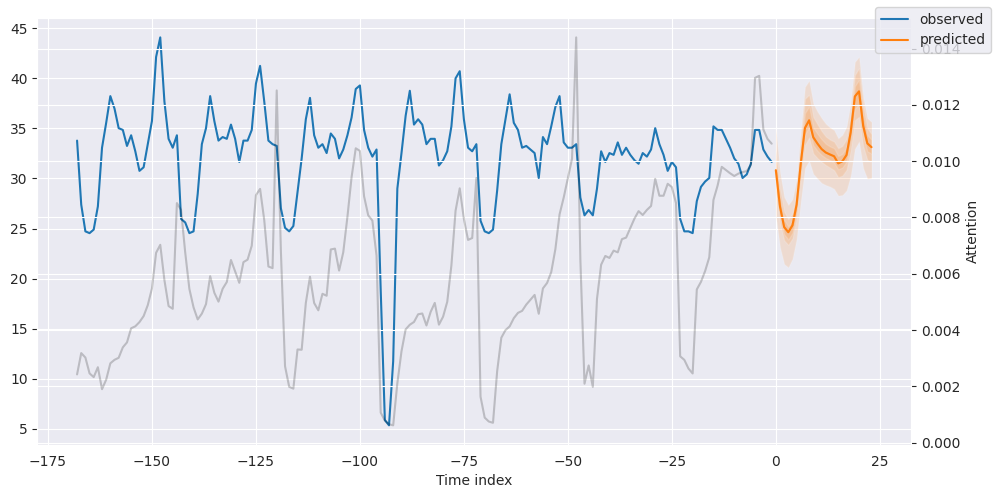

In [58]:
fig, ax = plt.subplots(figsize=(10, 5))

#create out-of-sample predictions for MT_002
new_prediction_data=new_prediction_data.query(" consumer_id == 'MT_002'")
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)
best_tft.plot_prediction(new_x, new_raw_predictions, idx=0, show_future_observed=False, ax=ax);


# Feature Importances

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x300 with 1 Axes>,
 'encoder_variables': <Figure size 700x375 with 1 Axes>,
 'decoder_variables': <Figure size 700x350 with 1 Axes>}

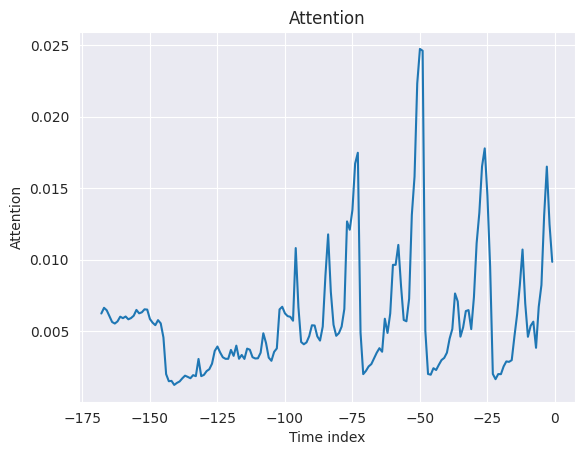

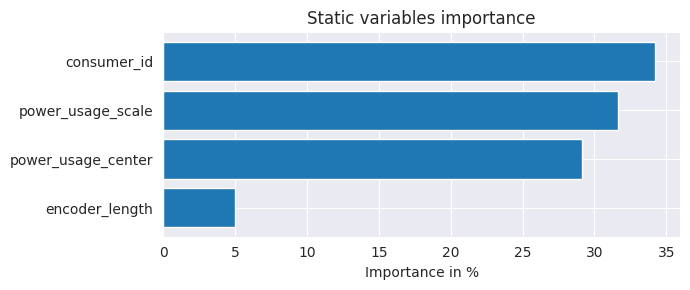

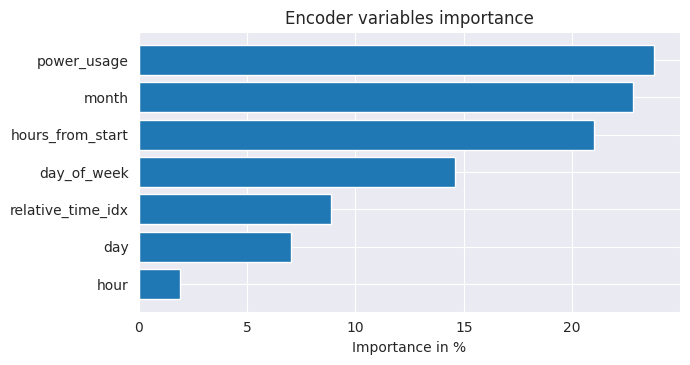

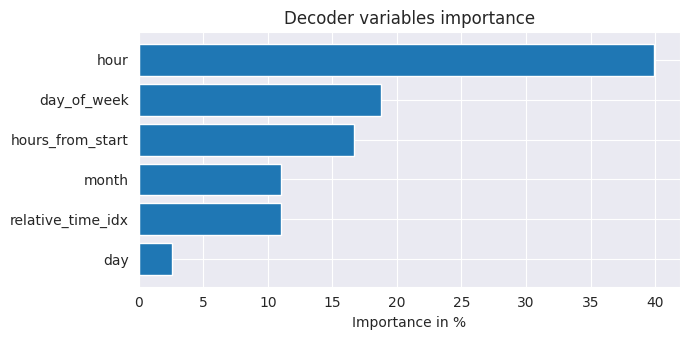

In [59]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

### Extreme Event Detection

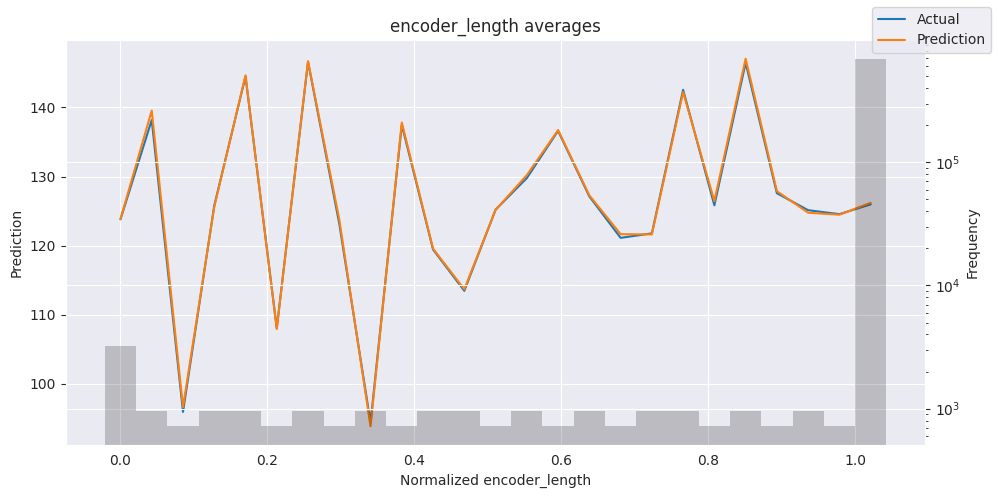

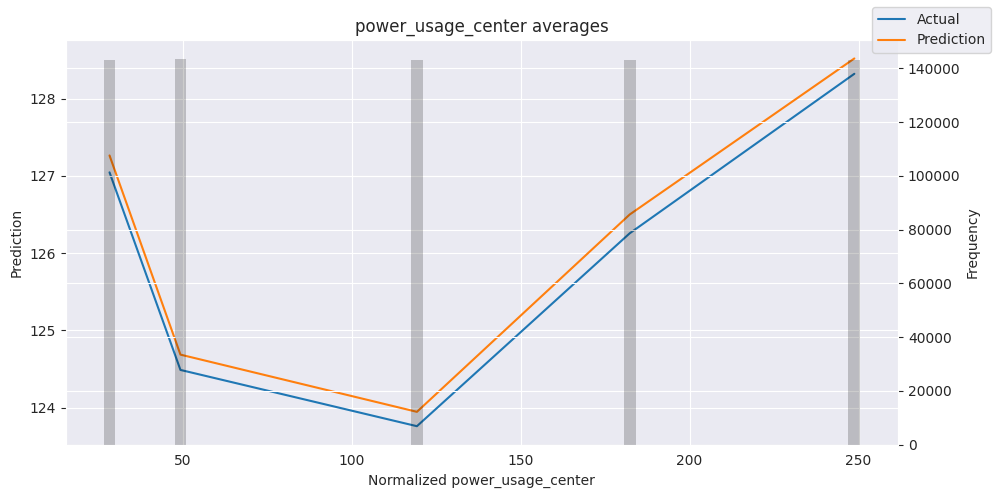

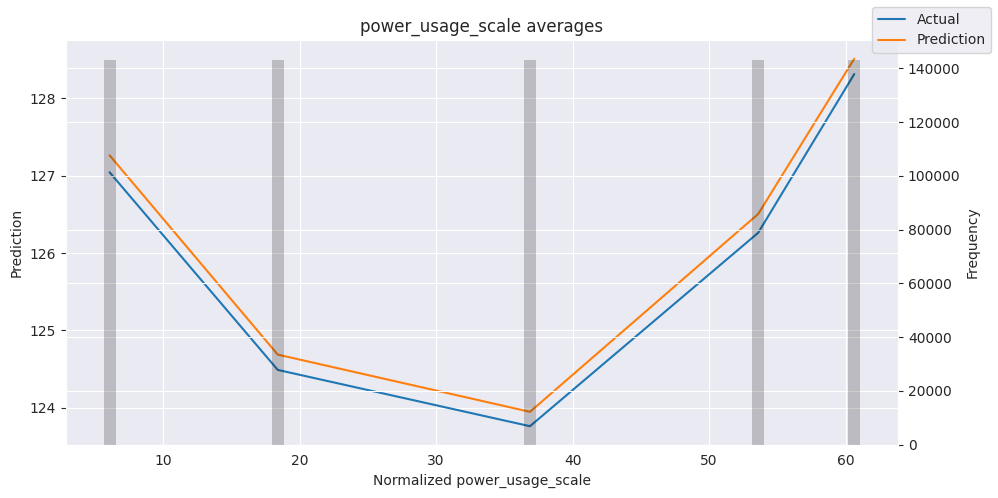

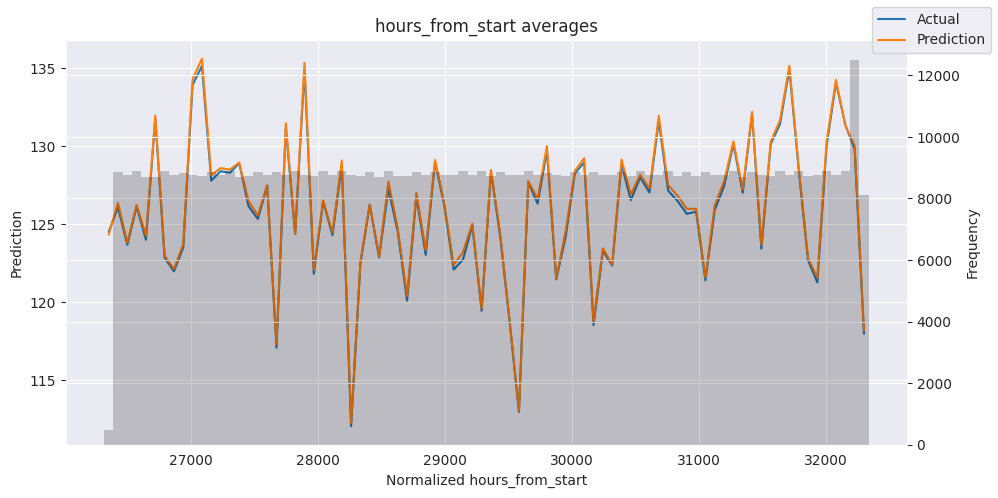

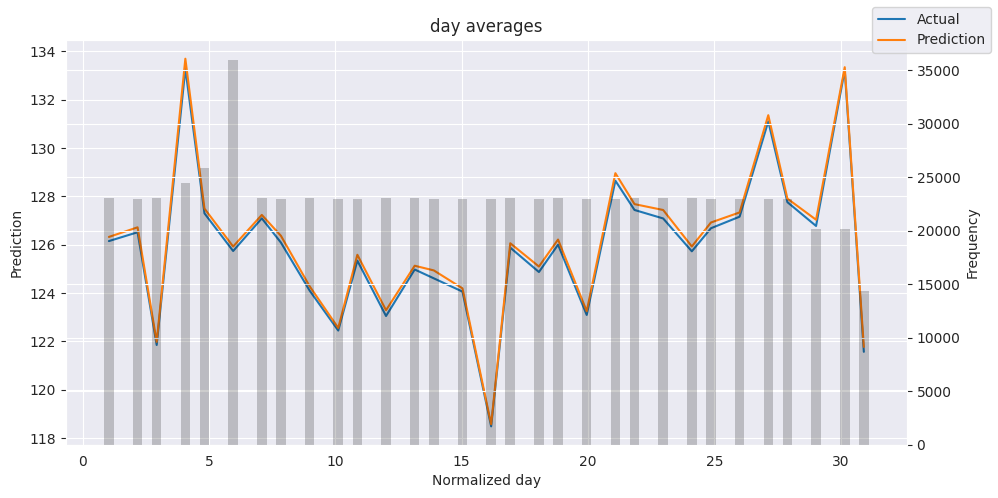

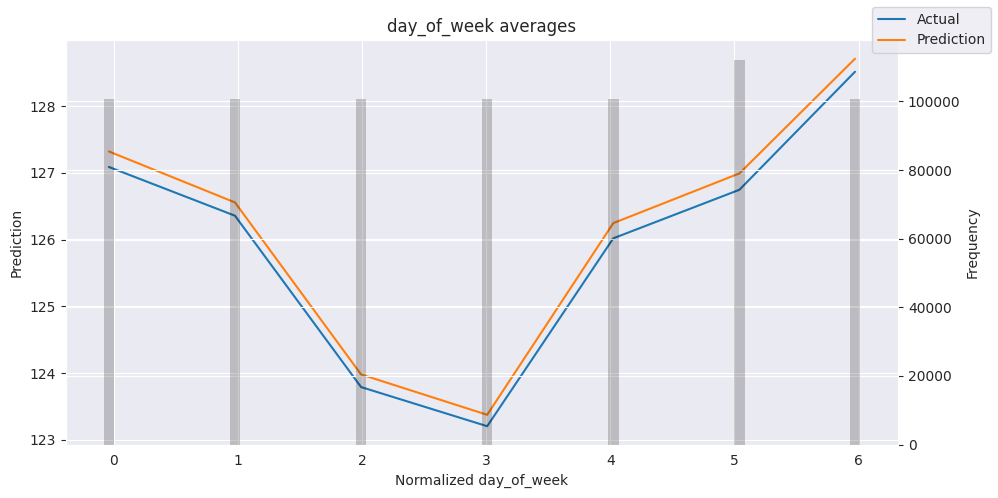

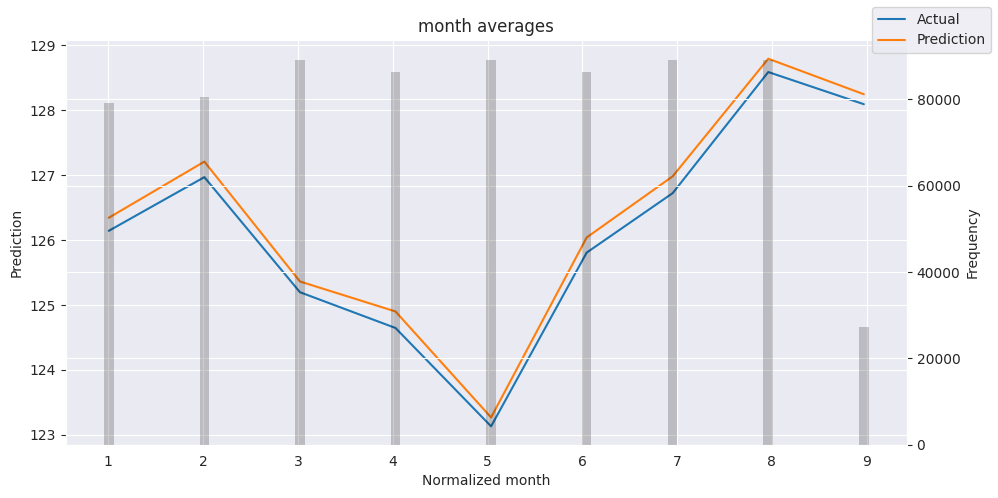

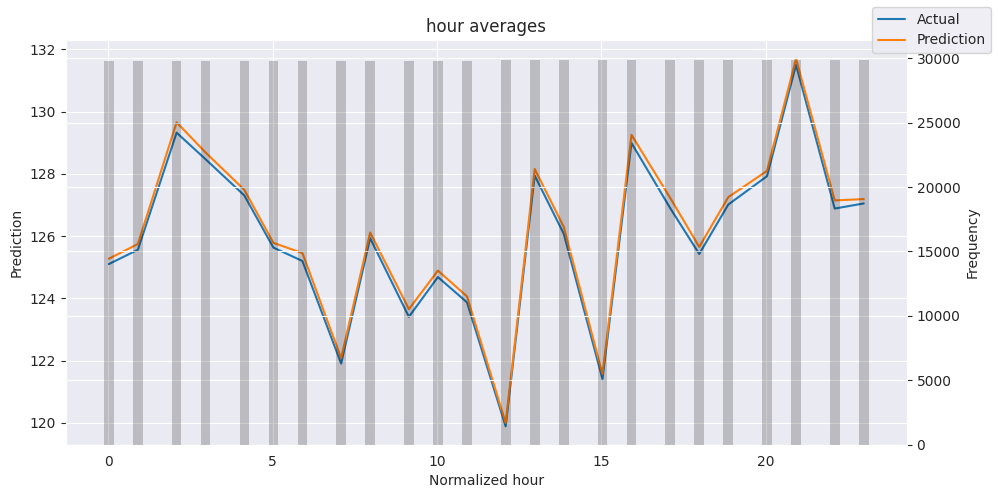

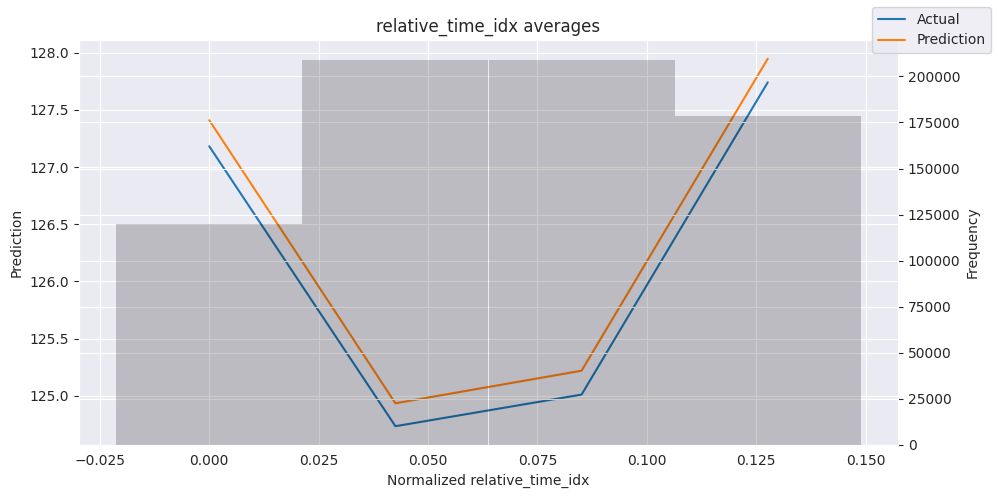

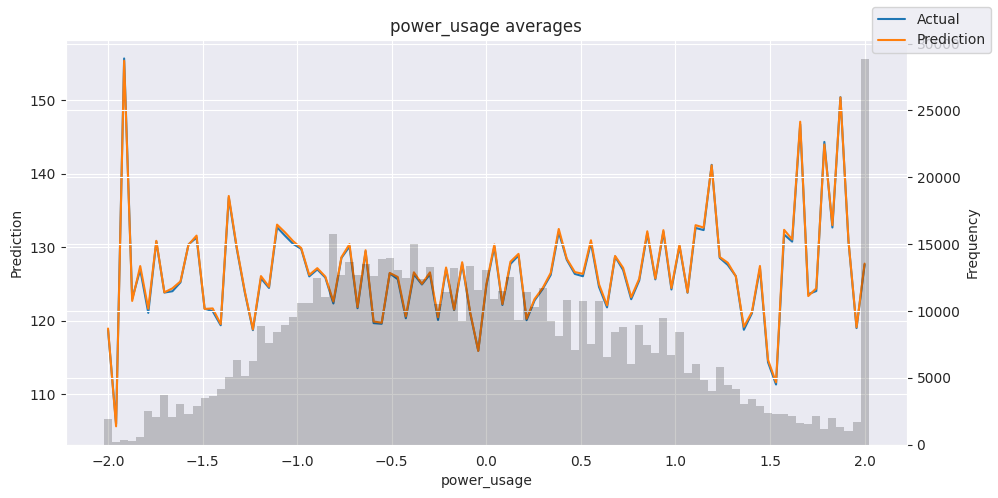

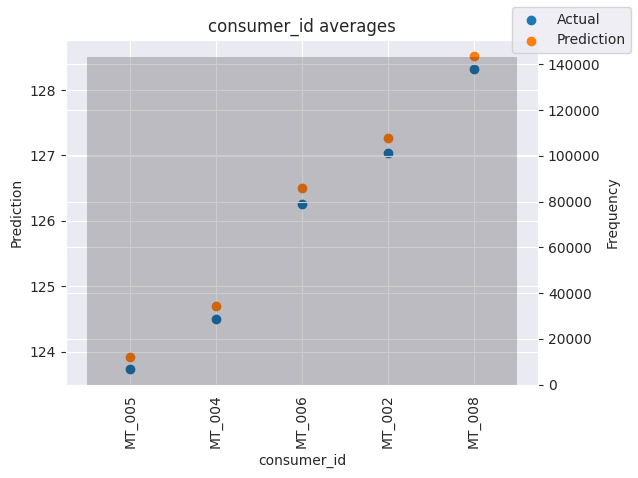

In [60]:
#Analysis on the training set
predictions, x = best_tft.predict(train_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

/usr/local/lib/python3.9/dist-packages/pytorch_forecasting/models/base_model.py:1699: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6
/usr/local/lib/python3.9/dist-packages/pytorch_forecasting/models/base_model.py:1699: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6
/usr/local/lib/python3.9/dist-packages/pytorch_forecasting/models/base_model.py:1699: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6
/usr/local/lib/python3.9/dist-packages/pytorch_forecasting/models/base_mo

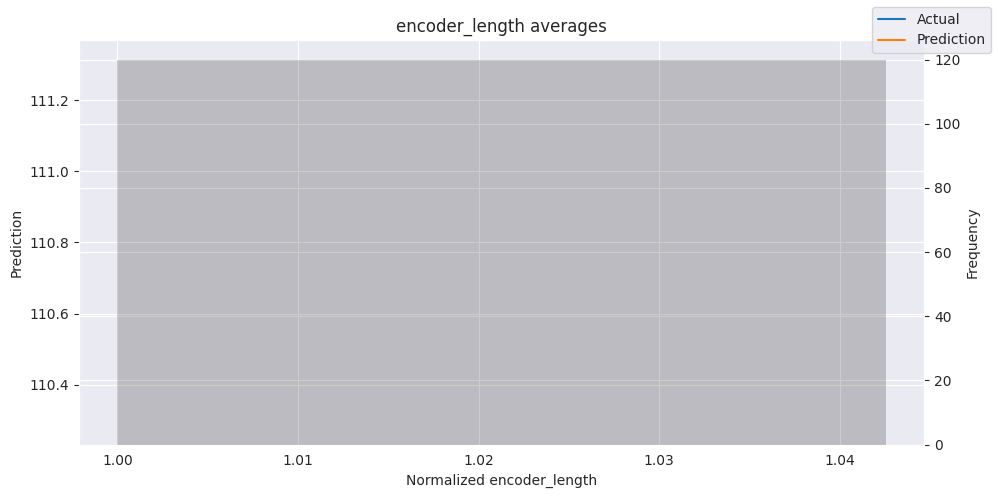

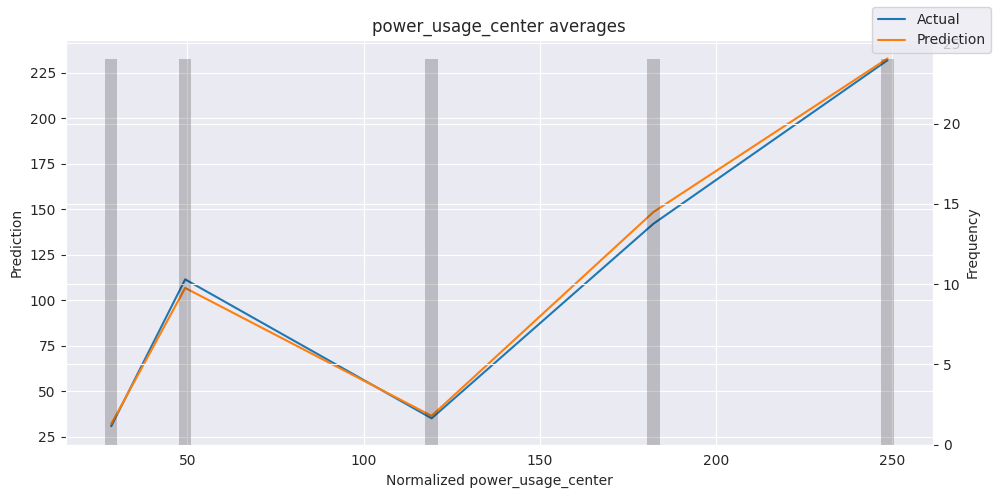

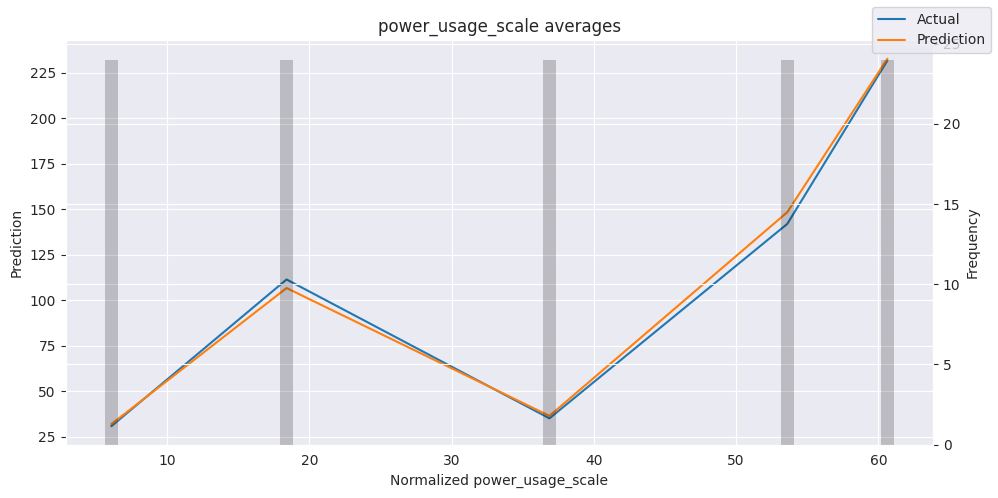

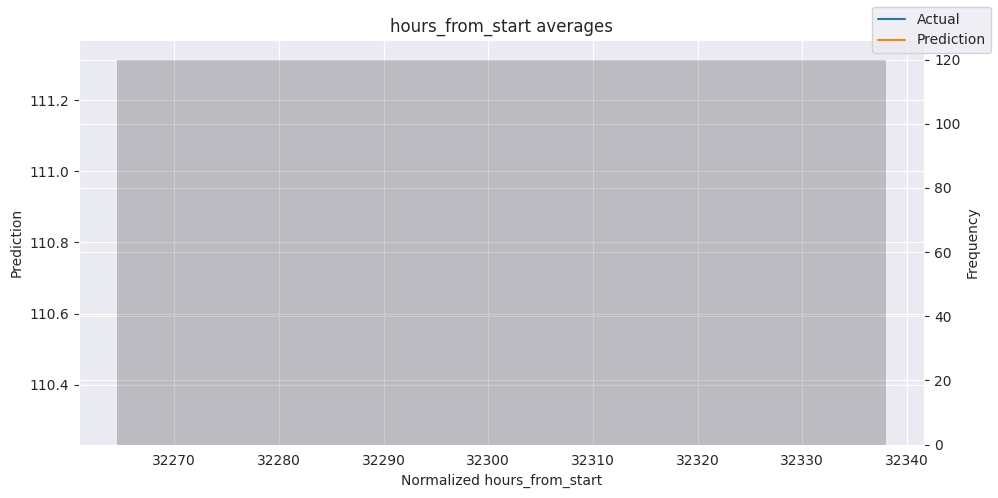

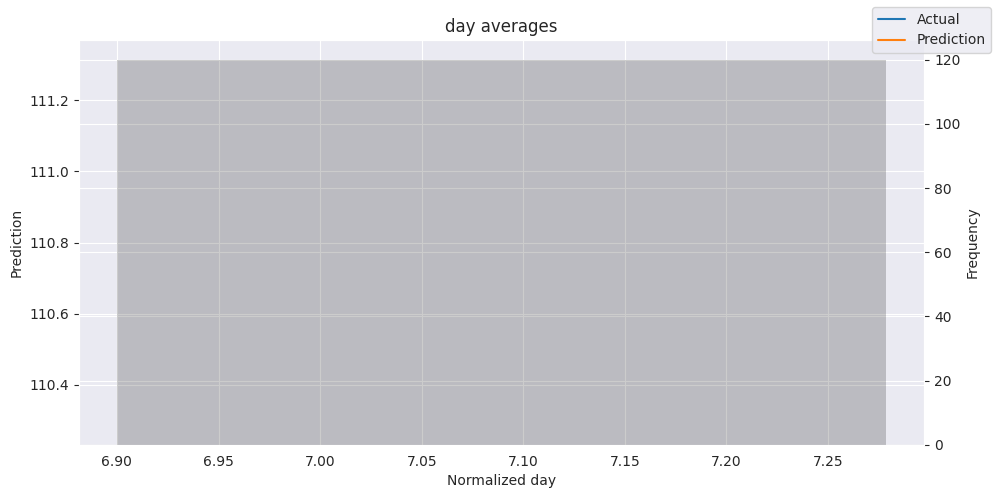

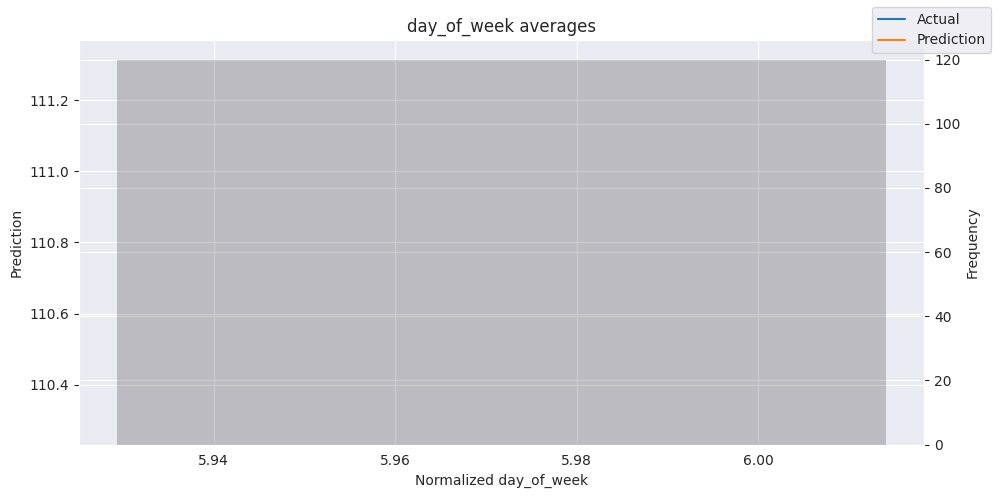

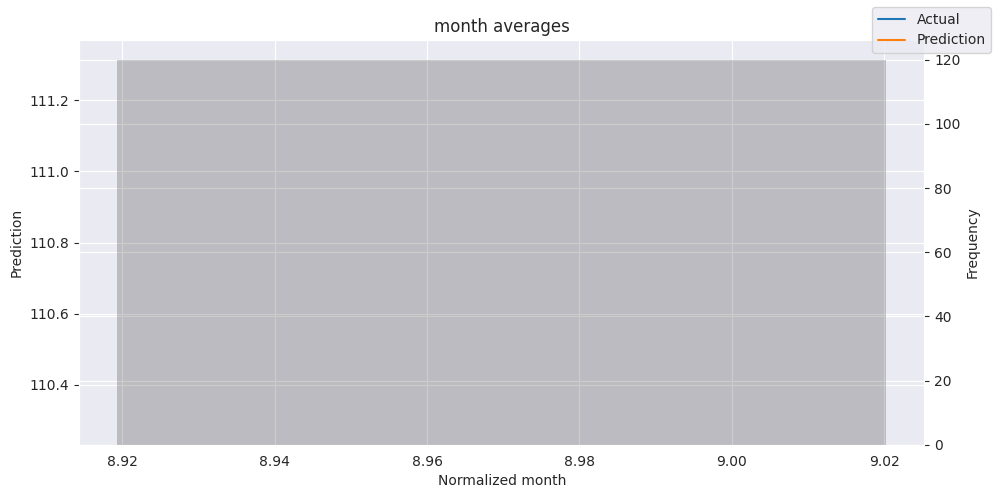

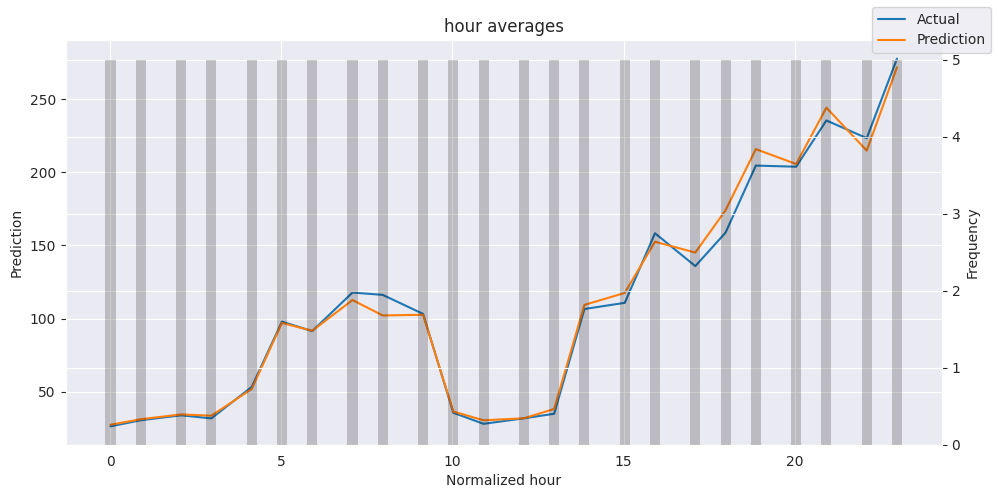

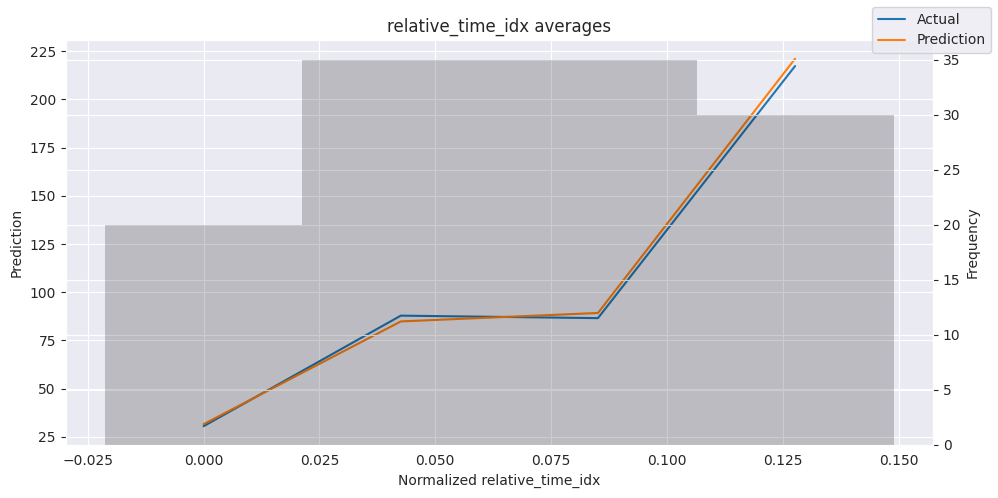

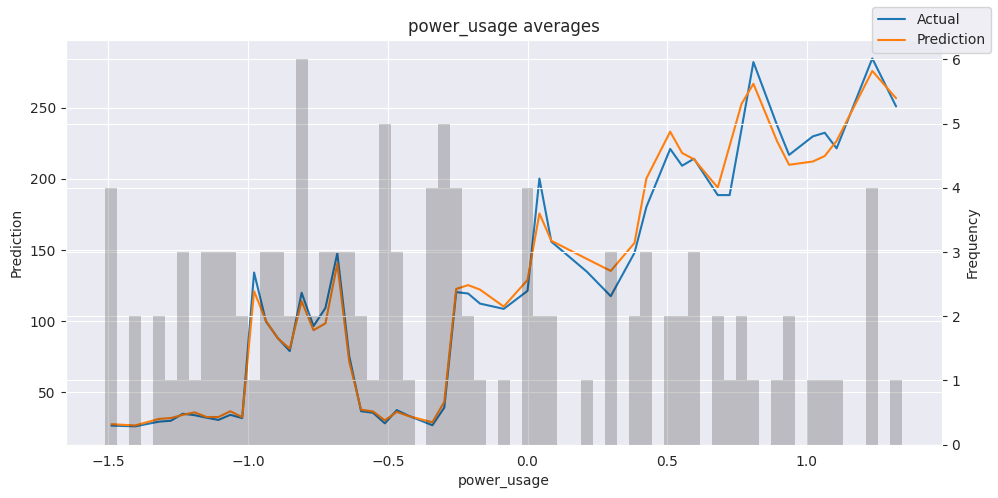

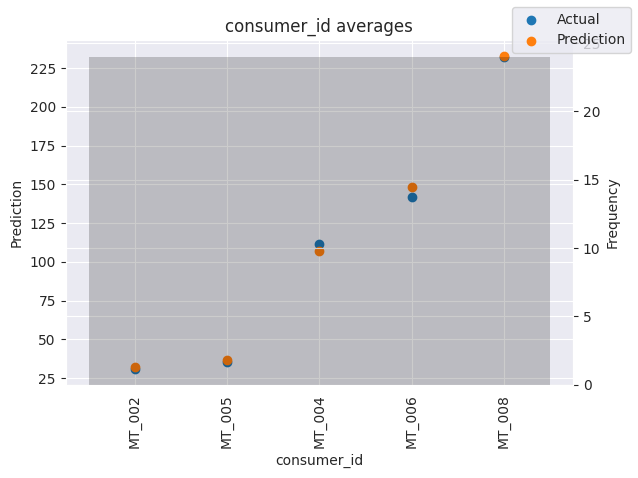

In [61]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

## Hyperparameter Tuning

In [62]:
# TFT can be used with optuna for hyperparameter tuning. We haven't used used it as the results with the initial
# hyperparameters taken were quite good.

# create a new study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=1,
    max_epochs=1,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(30, 128),
    hidden_continuous_size_range=(30, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False 
)

# save study results
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# print best hyperparameters
print(study.best_trial.params)

[I 2023-03-30 05:28:48,898] A new study created in memory with name: no-name-2f380388-5403-4889-be7c-4f1263092acc
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['

{'gradient_clip_val': 0.25367620157770376, 'hidden_size': 49, 'dropout': 0.2358525092155826, 'hidden_continuous_size': 32, 'attention_head_size': 2, 'learning_rate': 0.013356359923286036}


In [63]:
!pip show pytorch_forecasting

y
Name: pytorch-forecasting
Version: 0.10.3
Summary: Forecasting timeseries with PyTorch - dataloaders, normalizers, metrics and models
Home-page: https://pytorch-forecasting.readthedocs.io
Author: Jan Beitner
Author-email: 
License: 
Location: /usr/local/lib/python3.9/dist-packages
Requires: matplotlib, optuna, pandas, pytorch-lightning, scikit-learn, scipy, statsmodels, torch
Required-by: 
